In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter
%matplotlib inline

Load a mean pulse profile for B1957+20

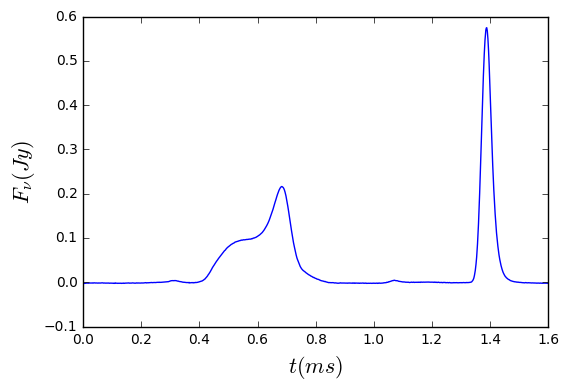

In [16]:
mean_profile = np.load('mean_profile.npy')

meanprof_Jy = (mean_profile / np.median(mean_profile) - 1) * 12.
#mean_value = (np.mean(mean_profile) / np.median(mean_profile) - 1) * 12.

#print("Mean pulse flux = %s Jy" % (mean_value))

n = 100000

x = np.arange(1000)
meanprof_inter = inter.interp1d(x, meanprof_Jy, kind='linear')
xnew = np.arange(0,1000-1,1000./n)
ynew = meanprof_inter(xnew)

plt.plot(xnew/1000.*1.6, ynew)
plt.xlabel('$t (ms)$', fontsize=16)
plt.ylabel(r'$F_{\nu} (Jy)$', fontsize=16)
#plt.xlim(0,1.6)
#plt.ylim(-.1, 0.6)

Invent some sinusoidal wave at frequency of observed band

(0.0, 10)

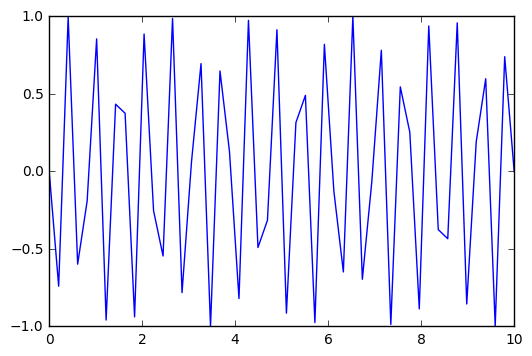

In [15]:
angular_freq = 2*np.pi*311.25*10e6 # Hz
t = np.linspace(0, n)*10e-3 # s
phase = np.sin(angular_freq*t)

plt.plot(t, phase)
plt.xlim(0.0, 10)

In [95]:
E_field = np.sqrt(meanprof_Jy)*phase

plt.plot(t, E_field)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


ValueError: operands could not be broadcast together with shapes (1000,) (1600,) 